# Signed Networks - Replication

The subject of this work will be to try to replicate **Table 1** and **Table 3** from the paper "Signed Networks in Social Media" from Jure Leskovec, Daniel Huttenlocher and Jon Kleinberg.

Authors paper: https://cs.stanford.edu/people/jure/pubs/triads-chi10.pdf <br>
Datasets: https://snap.stanford.edu/data/index.html

This notebook is organised as follow:
- [Data parsing](#Data_parsing)

- [Table 1](#table1)
    - [Replication results](#Replication_results1)
    - [Additional research](#Additional_research1)

- [Table 3](#table3)
    - [Replication results](#Replication_results3)
    - [Discussion](#Discussion)

In [1]:
# Imports and settings
import pandas as pd 
import networkx as nx
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import permutations
from IPython.display import display, HTML

# Display dataframes next to each other (doesn't work on git)
#CSS = """
#.output {
#    flex-direction: row;
#}
#"""
#display(HTML('<style>{}</style>'.format(CSS)))

## Data Parsing <a id='Data_parsing'></a>

In this part, we will organise the datasets such that there are structured the same way. 

In [2]:
# Data reading
data_folder = "Signed_Networks_Data/"

epinions = pd.read_table(data_folder + 'soc-sign-epinions.txt', 
                         names=['From node','To node','Weight'],comment='#',header=None).rename_axis('Epinions',axis=1)
slashdot = pd.read_table(data_folder + 'soc-sign-Slashdot090221.txt', 
                         names=['From node','To node','Weight'],comment='#',header=None).rename_axis('Slashdot',axis=1)
wikielec = pd.read_table(data_folder + 'wikiElec.ElecBs3.txt',
                         names=['Data format','A','B','C','D'],comment='#',header=None,
                         encoding = "ISO-8859-1").rename_axis('Wikipedia',axis=1)

Even though Wikipedia's dataset doesn't look like a usual table that we could automatically parse with `pandas`, it is still tab seperated and missing values can be replaced by "NaN" if the names of the columns are specified.
We also need a sepcial encoding `ISO-8859-1` to be able to read the data. We also name columns by default `A`, `B`, `C`, `D` as they don't represent one, but multiple types of data given by column `Data format`.

In [3]:
display(wikielec.head())

Wikipedia,Data format,A,B,C,D
0,E,1,NaN,NaN,NaN
1,T,2004-09-21 01:15:53,NaN,NaN,NaN
2,U,30,cjcurrie,NaN,NaN
3,N,32,andyl,NaN,NaN
4,V,1,3,2004-09-14 16:26:00,ludraman


For the replicaiton of the **Table 1** of the paper, we only need: 
- Source nodes (from nodes)
- Destination nodes (to nodes)
- Weights

So, in `wikielec` we can remove column C which contains times at which users voted, as well as column D which contains usernames of voters (redundant with user Id). We can also remove rows with `Data format` of `E`, `T`, and `N` which don't provide useful information either. The `epinions` and `slashdot` datasets provide just what we need and their reading with pandas is straightforward.

In [4]:
# WikiElec restructuring: we remove all rows with E,N and T data format and drop C and D columns
# Column A has destination node when data format is U and weight when data format is V
# Column B has username when data format is U and source node when data format is V
wikielec = wikielec[wikielec['Data format'] != 'E']
wikielec = wikielec[wikielec['Data format'] != 'N']
wikielec = wikielec[wikielec['Data format'] != 'T']
wikielec.drop(['C','D'],axis=1,inplace=True)
wikielec.reset_index(inplace=True,drop=True)

display(wikielec.head())

Wikipedia,Data format,A,B
0,U,30,cjcurrie
1,V,1,3
2,V,-1,25
3,V,1,4
4,V,1,5


Now that `wikielec` provides only what we need, we can organize the data such that all three of the datasets are strucutred in the same way: 

In [5]:
# Structure like Epinions and Slashdot: rows of [from_node,to_node,weight]
data = []
for idx in wikielec.index:
    # When data format is 'U', we update the destination node and continue
    if wikielec['Data format'][idx] == 'U':
        to_node = int(wikielec['A'][idx])
        continue
    
    # When data format is 'V', we can append [from_node,to_node,weight]
    from_node = int(wikielec['B'][idx])
    weight    = int(wikielec['A'][idx])
    if weight != 0:
        data.append([from_node,to_node,weight])
    
wikielec = pd.DataFrame(data=np.array(data),columns=epinions.columns).rename_axis('Wikipedia',axis=1)

In [6]:
# Display of the same structures datasets
display(epinions.head())
display(slashdot.head())
display(wikielec.head())

Epinions,From node,To node,Weight
0,0,1,-1
1,1,128552,-1
2,2,3,1
3,4,5,-1
4,4,155,-1


Slashdot,From node,To node,Weight
0,0,1,1
1,0,2,1
2,0,3,1
3,0,4,1
4,0,5,1


Wikipedia,From node,To node,Weight
0,3,30,1
1,25,30,-1
2,4,30,1
3,5,30,1
4,6,30,1


Now that our dataframes are structured the same, we can process their statisitcs similarly. First let's check their duplicates:

In [7]:
# Check for duplicates
print("Number of duplicated edges (edges with same source and destination nodes)")
print("Epinions: %d"%epinions[['From node','To node']].duplicated().sum())
print("Slashdot: %d"%slashdot[['From node','To node']].duplicated().sum())
print("Wikipedia: %d"%wikielec[['From node','To node']].duplicated().sum())

Number of duplicated edges (edges with same source and destination nodes)
Epinions: 0
Slashdot: 0
Wikipedia: 3333


We see that only Wikipedia's dataset have some duplicates. We will see later how this is handled.

## Table 1 <a id='table1'></a>

Before we start, we can aslo build a constant table for table 1 of the paper as well as global table for the results we will find. We will then be able to compare the results more easily.

In [8]:
# Constant dataframe for paper results
PAPER_RESULTS_TABLE1 = pd.DataFrame(data =  [['119,217'   ,'82,144'   ,'7,118'  ],
                                            ['841,200'   ,'549,202'  ,'103,747'],
                                            ['85.0%'     ,'77.4%'    ,'78.7%'  ],
                                            ['15.0%'     ,'22.6%'    ,'21.2%'  ],
                                            ['13,375,407','1,508,105','790,532']],
                                    index  =['Nodes','Edges','+ edges','- edges','Triads'],
                                    columns=['Epinions','Slashdot','Wikipedia'])\
                                   .rename_axis('Paper results - Table 1',axis=1)

# Global dataframe for replication results 
results_table1 = (PAPER_RESULTS_TABLE1*0).rename_axis('Replication results - Table 1',axis=1)

display(PAPER_RESULTS_TABLE1)
display(results_table1)

Paper results - Table 1,Epinions,Slashdot,Wikipedia
Nodes,"119,217","82,144","7,118"
Edges,"841,200","549,202","103,747"
+ edges,85.0%,77.4%,78.7%
- edges,15.0%,22.6%,21.2%
Triads,"13,375,407","1,508,105","790,532"


Replication results - Table 1,Epinions,Slashdot,Wikipedia
Nodes,,,
Edges,,,
+ edges,,,
- edges,,,
Triads,,,


### Replication results  <a id='Replication_results'></a>

We will now try to fill in a replication table and compare it to the paper results. We start to implement the following reusable function:

In [9]:
def fill_replication_results(dataframe):
    """ Save number of nodes and edges, percentage of +1 and -1 weights
        and number of undirected triangles of dataframe into results table """
   
    global results_table1
    
    # Construct the graph of the dataframe
    G = nx.DiGraph()
    G.add_weighted_edges_from(map(tuple,dataframe.values))

    # Number of nodes and edges
    nb_nodes = G.number_of_nodes()
    nb_edges = G.number_of_edges()
    
    # Proportion of + and - signs in dataset 
    # (not fastest way obviously but we want to stay consistent with networkx)
    percent_plus_edges  = 100*len([(u,v,w) for (u,v,w) in G.edges(data='weight') if w== 1])/nb_edges
    percent_minus_edges = 100*len([(u,v,w) for (u,v,w) in G.edges(data='weight') if w==-1])/nb_edges
    
    # Number of triangles in the undirected graph (lasts 40 secs with epinions)
    G_undirected = G.to_undirected()
    triangles    = nx.triangles(G_undirected)
    nb_triangles = int(sum(triangles.values())/3)
    
    # Save results
    results_table1[dataframe.columns.name] = ["{:,}"  .format(nb_nodes),
                                       "{:,}"  .format(nb_edges),
                                       "{:.1f}".format(percent_plus_edges)  + '%',
                                       "{:.1f}".format(percent_minus_edges) + '%',
                                       "{:,}"  .format(nb_triangles)]
                                      

In [10]:
# Epinions
fill_replication_results(epinions)

display(PAPER_RESULTS_TABLE1)
display(results_table1)

Paper results - Table 1,Epinions,Slashdot,Wikipedia
Nodes,"119,217","82,144","7,118"
Edges,"841,200","549,202","103,747"
+ edges,85.0%,77.4%,78.7%
- edges,15.0%,22.6%,21.2%
Triads,"13,375,407","1,508,105","790,532"


Replication results - Table 1,Epinions,Slashdot,Wikipedia
Nodes,"131,828",,
Edges,"841,372",,
+ edges,85.3%,,
- edges,14.7%,,
Triads,"4,910,076",,


The first dataset that we are looking into is `epinions`. At first glance, we see that none of the values that we find are exactly the same as those in the paper. 
- A first possiblity is that we made a mistake in the calculation, but when using other techniques (like `numpy` or `pandas`), we still get the same results. Other techniques are shown in [Additional research](#Additional_research) part.
- Another possibility is that the authors processed the data in some way that they didn't explicitly explained in the paper. In that case, there is not much that we can do.
- A last possiblity is that the authors didn't use the same version of the dataset that we have. If we look at the provenance of the dataset and simply type "Signed networks datasets" on Google, we find the website of Stanford large network dataset collection [SNAP](https://snap.stanford.edu/data/). If we further look into the datasets that they offer, we find out that there are two datasets for epinions: [soc-Epinions1](https://snap.stanford.edu/data/soc-Epinions1.html) and [soc-sign-epinions](https://snap.stanford.edu/data/soc-sign-epinions.html). If we look at the second of them, we see that the stats of the dataset are exactly the same as those we have: 131,828 nodes and 841,372 edges. We see that we also have the same number of triangles calculated (4,910,076). We don't have the statistics for the percentage of positive and negative weights but we can fairly assume that these results are correct being given that they are very close to the paper results and that all other results are equal to those on the SNAP website.

Note that the number of triads in the paper is a lot larger than the number of triads we calculated. Indeed, we calculate the number of triangles in the **undirected** graph of epinions, loosing information about nodes that have a pair of directed edges between them (reciprocal edges). It is not explicitly stated in the paper, but here again, we can fairly assume that the authors counted the number of triads in the **directed** graphs.

Let's continue with the other datasets and compare the results:

In [11]:
# Slashdot
fill_replication_results(slashdot)

display(PAPER_RESULTS_TABLE1)
display(results_table1)

Paper results - Table 1,Epinions,Slashdot,Wikipedia
Nodes,"119,217","82,144","7,118"
Edges,"841,200","549,202","103,747"
+ edges,85.0%,77.4%,78.7%
- edges,15.0%,22.6%,21.2%
Triads,"13,375,407","1,508,105","790,532"


Replication results - Table 1,Epinions,Slashdot,Wikipedia
Nodes,"131,828","82,140",
Edges,"841,372","549,202",
+ edges,85.3%,77.4%,
- edges,14.7%,22.6%,
Triads,"4,910,076","579,565",


Using the same function `fill_replication_results`, we calculate the statistics for `slashdot` dataset. We see that every statistic corresponds perfectly except for the number of nodes (paper has 4 more than replication) and the number of triangles. Here again we can refer to [SNAP](https://snap.stanford.edu/data/) and look for Snapshot datasets. We can find several of them but we are especially interested in this one: [soc-sign-Slashdot090221](https://snap.stanford.edu/data/soc-sign-Slashdot090221.html) (which has the same name as the one we have. Here again we see that we found the same results as those on this webpage (82,140 nodes, 579,565 triangles etc...). Note that on [SNAP](https://snap.stanford.edu/data/) webpage which summarises all datasets, we can see that there are 82,144 nodes in the summary description of our dataset which might be the source of confusion.

We still have a large difference in the number of triads between the paper and the replication results because of the same reason that we stated above.

Let's now finish with the last `wikielec` dataset: 

In [12]:
# Wikipedia
fill_replication_results(wikielec)

display(PAPER_RESULTS_TABLE1)
display(results_table1)

Paper results - Table 1,Epinions,Slashdot,Wikipedia
Nodes,"119,217","82,144","7,118"
Edges,"841,200","549,202","103,747"
+ edges,85.0%,77.4%,78.7%
- edges,15.0%,22.6%,21.2%
Triads,"13,375,407","1,508,105","790,532"


Replication results - Table 1,Epinions,Slashdot,Wikipedia
Nodes,"131,828","82,140","7,118"
Edges,"841,372","549,202","103,747"
+ edges,85.3%,77.4%,78.8%
- edges,14.7%,22.6%,21.2%
Triads,"4,910,076","579,565","608,389"


For `wikielec` dataset, we also obtain the exact same results than in the paper except for the triangle (still same reason as above), and surprisingly for the percentage of positive signs which differs from 0.1%. 
- A first possibility to have this small difference could be that we made a mistake in our calculation of the percentages or in the format with which we show the results.
- A second possibility is that the author rounded the results down. Indeed, the result of the positive percentage with 3 decimals place is 78.786%. If the author rounded it down (which would seems strange), the result to one decimal place would be 78.7 and our result would be (rounded to closest) 78.8%. But this would be plausible if all other percentages calculated were to be rounded down anyway (second decimal below 5). However, this is not the case because the percentage of positive edges in `slashdot` is 77.398%. So this hypothese is not really plausible.
- A last possiblity would be that the results of the paper were filled in by hand and subjected to mistakes.

We saw that Wikipedia's dataset had 3333 duplicates. But, we watched for duplicates of the directed edges only (source and destination nodes) and didn't take into account the weight of the duplicated edge. So if two duplicated edges have the same weight, it becomes a totally duplicated edge and it doesn't matter which one is chosen. But if two duplicated edges have different weights, what will then happen ? In the manner we calculate it with `networkx` (and because we use a directed graph and not a muti-directed graph), the **last** duplicated edge read in the table will overwrite the first duplicated edge when creating the directed graph.

In [13]:
print("Wikipedia's number of duplicated edges (without weight): %d"%wikielec[['From node','To node']].duplicated().sum())
print("Wikipedia's number of totally duplicated edges (with weight): %d"%wikielec.duplicated().sum())

Wikipedia's number of duplicated edges (without weight): 3333
Wikipedia's number of totally duplicated edges (with weight): 2721


There are 3333 duplicated edges (same source and destination nodes) among which 2721 edges are totally duplicated (same source and destination nodes **and** weight). So, there are $3333-2721=612$ edges with a duplicate of the opposite weight. So, only 612 edges out of 1224 will be chosen to be part of the graph. The percentage of positive and negative signs in the graph depends on which 612 edges are chosen and this is could be a reason why the replication doesn't lead to the same results as those in the papers. More explanations are shown in [Additional research](#wiki) part.

But even condisering the situation explained above, both the replication and the paper still have the same 21.2% of negatives signs, so how is it possible that the percentage of positives is different if it is simply the complementary percentage to get to a 100? It is not. Indeed, the sum of percentages in the paper is different from 100: $21.2 + 78.7 = 99.9 \%$. And this is not because of the blank votes of 0 because there are 6960 of them which makes a percentage of: $$\frac{6960}{103747 + 6960}=6\%>>0.1\%$$

So the most probable hypotheses are either that the authors didn't round their results properly or that they made mistakes when filling the tables on the paper by hand.

#### Triads

As we explained in the previous part, the number of triangles is calculated on the undirected graph of the datasets. This allowed us to compare another statistic with [SNAP](https://snap.stanford.edu/data/) website to argue as much as possible on the plausibility of our replication. But the values are too different from those of the paper and this is probably due to the fact that the authors of the paper also considered directed edges.

We didn't find any fast and easy solutions to calculate triads in a directed graph on internet, so we decided to implement our own solution. Multiple techniques have been studied (see [here](#triads)) but the following seems to give the best compromise between easy implementation and low computationnal complexity. 

In [14]:
def number_of_triads(dataframe):
    """ Calculate number of triads in a directed graph """
    
    global results_table1
    
    # Create graph for the data
    G = nx.DiGraph()
    G.add_weighted_edges_from(map(tuple,dataframe.values))
    
    # Save an undirected version of the graph for neighbors search
    G_undirected = G.to_undirected()

    # Algorithm for counting triads with neighbor chain search
    n = 0
    # For each node
    for node in list(G_undirected.nodes()):
        neighbor_done = []
        # Iterate through node neighbors
        for neighbor in nx.neighbors(G_undirected,node):
            # Avoids self-loops
            if neighbor != node:
                # Avoids itterating multiple times the same triad
                neighbor_done.append(neighbor)
                # Iterate through common neighbors of the node and the neighbor
                for common in nx.common_neighbors(G_undirected,node,neighbor):
                    if common not in neighbor_done:
                        # Formula: 2^(sum of all directed edges in triad - 3)
                        n += 2**(sum([perm in G.edges() for perm in permutations([node,neighbor,common],2)])-3)
        # Avoids going through same triads twice and greatly diminish complexity 
        G_undirected.remove_node(node)
    
    # Save results
    results_table1[dataframe.columns.name]['Triads'] = "{:,}".format(n)

In this algorithm, we iterate through each node and each of their neighbors. We use the undirected graph version for iterating throught nodes, neighbors and common neighbors as it is faster, easier and that we simply don't need the directed graph for these steps. Once we find a triangle, then we look at the corresponding nodes in the directed graph as the nodes don't change from undirected to directed. So, we then look how many edges connect all these three nodes in the directed graph. We can have between 3 and 6 edges (2 maximum between 2 nodes) connecting 3 nodes and each edge added between the nodes multiplies the possible number of triangle by 2 (3 edges: 1 triad, 4 edges: 2 triads, 5 edges: 4 triads, 6 edges: 8 triads). 

So the formula for the number of triads in a group of 3 nodes becomes: 
$$n = 2^{\sum (edges)  - 3}$$

The last step is to remove the treated node so that triads are not calculated twice and that the computational complexity diminishes.

In [15]:
# 2.4 GHz CPU
%time number_of_triads(epinions)

CPU times: user 4min 43s, sys: 477 ms, total: 4min 44s
Wall time: 4min 44s


In [16]:
%time number_of_triads(slashdot)

CPU times: user 1min 46s, sys: 171 ms, total: 1min 46s
Wall time: 1min 46s


In [17]:
%time number_of_triads(wikielec)

CPU times: user 20.9 s, sys: 35.3 ms, total: 20.9 s
Wall time: 20.9 s


In [18]:
display(PAPER_RESULTS_TABLE1)
display(results_table1)

Paper results - Table 1,Epinions,Slashdot,Wikipedia
Nodes,"119,217","82,144","7,118"
Edges,"841,200","549,202","103,747"
+ edges,85.0%,77.4%,78.7%
- edges,15.0%,22.6%,21.2%
Triads,"13,375,407","1,508,105","790,532"


Replication results - Table 1,Epinions,Slashdot,Wikipedia
Nodes,"131,828","82,140","7,118"
Edges,"841,372","549,202","103,747"
+ edges,85.3%,77.4%,78.8%
- edges,14.7%,22.6%,21.2%
Triads,"13,317,672","1,508,105","790,532"


Finally, we have all the results. We obtain the exact same number of triads for `wikielec` and `slashdot` datasets as those in the paper. Despite having more nodes in our `epinions` dataset than that of the paper, we obtain a smaller number of triads. There may be a chance that the algorithm that we implemented has some issues and does not take into account all possible aspects of a graph. Otherwise, our `epinions` graph is simply more connected and forms more triangles.

The complexity of the algorithm seems to be proportionnal to the number of edges for `wikielec` and `slashdot`. Indeed, `wikielec` has ~100k edges in 20 seconds, `slashdot` has approximatly 5 times more ~500k edges in 100 seconds. `epinions` seems to be a little longer with ~800k edges in 250 seconds.

<a id='Additional_research'></a>
### Additional research

This part explains intermediate steps before reaching the final results that we showed in the previous part.

#### Triads <a id='triads'></a>

##### Connectivity
This part shows how we wanted to take advantage of the connectivity algorithms proposed by `networkx` to discard elements that are not useful to calculate the triads. For example all connected components of less than 3 elements can be removed from the graph as they cannot form any triad. So we first check if G is connected. For that we need the undirected version of G only:

In [19]:
G = nx.DiGraph()
G.add_weighted_edges_from(map(tuple,epinions.values))
G_undirected = G.to_undirected()
print(nx.is_connected(G_undirected))

False


So the undirected graph isn't connected which means that the graph contains components that are not linked to other components in any way. Let's check how many components are there:

In [20]:
nb_components = nx.number_connected_components(G_undirected)
print("Number of connected components: %d"%nb_components)

Number of connected components: 5816


That is a lot of components, let's now plot their sizes:

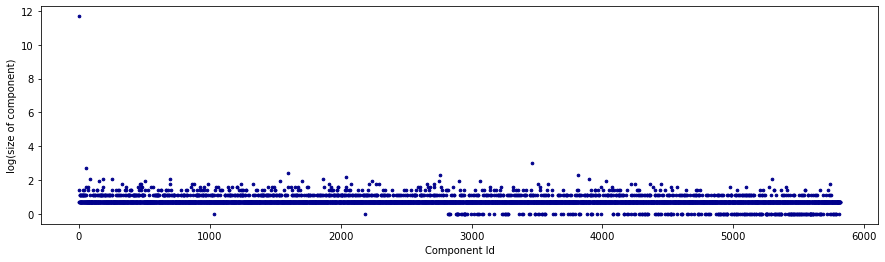

Size of biggest component: 119130


In [21]:
# List of all components sizes
size_components = [len(c) for c in nx.connected_components(G_undirected)]
#Plot
plt.figure(figsize=(15,4))
plt.scatter(np.arange(len(size_components)),np.log(size_components),s=7,color='darkblue')
plt.ylabel("log(size of component)")
plt.xlabel("Component Id")
plt.show()
print("Size of biggest component: %d"%max(size_components))

We see that we have a main (giant) component of size 119130 and many other smaller components. Let's now plot the number of components of each size **except for the giant component**.

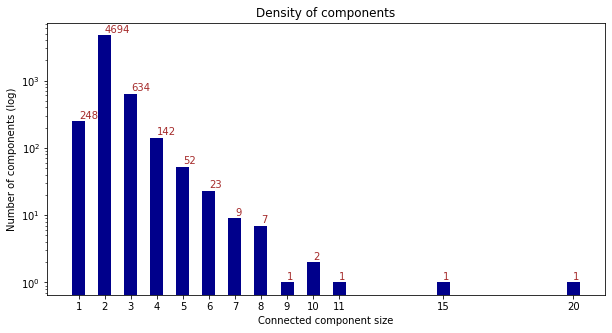

In [22]:
size_components = [len(c) for c in nx.connected_components(G_undirected)]
size_components = np.array(size_components)

# Calculates the number of components for each size under 25 
size_density = [sum(size_components==i) for i in np.unique(size_components) if i < 25]
# Plot
plt.figure(figsize=(10,5))
plt.bar(np.unique(size_components)[:-1],size_density,log=True,width=0.5,color='darkblue')
plt.xticks(np.unique(size_components)[:-1])
plt.xlabel("Connected component size")
plt.ylabel("Number of components (log)")
plt.title("Density of components")

for i, v in enumerate(size_density):
    plt.text(np.unique(size_components)[i],1.1*v,str(v),color='brown')

plt.show()

We see that we have 4694 components of size 2 and 248 components of size one that we can remove ! That's almost 4% of the nodes that we can discard before trying to find all triads (pre-processing).

In [23]:
def number_of_triads_v2(data):
    """ This function is a copy of function 'number_of_triads' 
        but components of size less than 3 are removed before """
    
    G = nx.DiGraph()
    G.add_weighted_edges_from(map(tuple,data.values))
    G_undirected = G.to_undirected()
    
    # Removes components of size less than 3
    small_components = []
    for c in nx.connected_components(G_undirected):
        # Components of size 1
        if len(c) == 1:
            small_components.append(list(c)[0])
        # Components of size 2
        if len(c) == 2:
            l = list(c)
            small_components.append(l[0])
            small_components.append(l[1])

    G_undirected.remove_nodes_from(small_components)
    
    # Same algorithm to calculate number of triads
    n = 0
    for node in list(G_undirected.nodes()):
        neighbor_done = []
        for neighbor in nx.neighbors(G_undirected,node):
            if neighbor != node:
                neighbor_done.append(neighbor)
                for common in nx.common_neighbors(G_undirected,node,neighbor):
                    if common not in neighbor_done:
                        n += 2**(sum([perm in G.edges() for perm in permutations([node,neighbor,common],2)])-3)
        G_undirected.remove_node(node)
    print(n)

In [24]:
%time number_of_triads_v2(epinions)

13317672
CPU times: user 4min 40s, sys: 560 ms, total: 4min 41s
Wall time: 4min 41s


Fortunately we get the same results of 13,317,672 triads. But the algorithm's running time isn't much different. This is due to the fact that the algorithm that we built before already discards small components (with few neighbors) very quickly and directly remove them from the graph. Here we go through all nodes multiple times: first we find the components, then we select the ones to discard, then remove them from the graph and finally run the algorithm. In the end, both techniques remain similar.

#### K-edge components

Even better than looking at connectivity is to look at the k-edge components. K-edges components are the biggest components of the graph that you cannot disconnect when removing fewer than k edges. So, when counting triads, we can be sure that 2-edges components of size 1 won't be usefull. That means that all these components can be discarded (there are no components of size 2 by definition). 

The following graph gives an example of a 2-edges component segmentation. We can see that the node 4 cannot form any triads in any ways and the typical way to isolate this type of node is to use 2-edges components. We can see in the list above the graph that we can easily isolate the node 4 as it is the only component of size 1. So the idea is to remove all nodes in 2-edges components of size 1.

[{0, 1, 2, 3}, {4}, {8, 9, 10}, {5, 6, 7}]


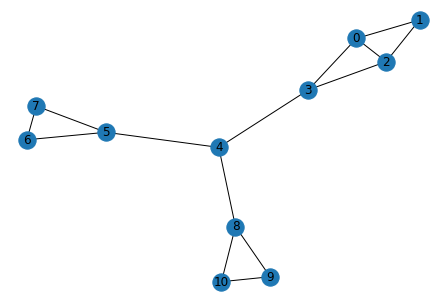

In [25]:
G_example = nx.Graph()
G_example.add_edges_from([(1,0),(3,2),(0,3),(0,1),(1,2),(2,0),(2,3),(3,0),(3,4),
                          (4,8),(9,8),(9,10),(8,10),(4,5),(5,6),(6,7),(7,5)])
nx.draw(G_example,with_labels=True)
print(list(nx.k_edge_components(G_example,2)))

So, just as we did for the connected components, we can plot the number of 2-edges components of each size. Note that we directly discard the giant 2-edges component.

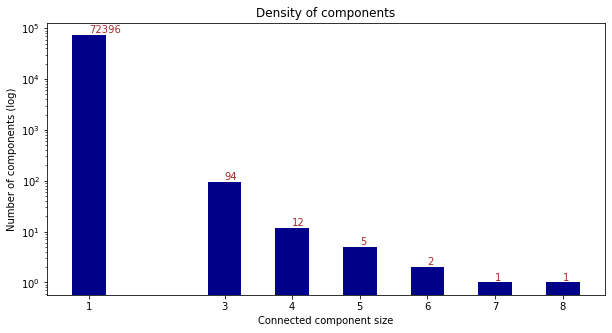

In [26]:
size_components = [len(c) for c in nx.k_edge_components(G_undirected,2)]
size_components = np.array(size_components)

# Calculates the number of components for each size under 25 
size_density = [sum(size_components==i) for i in np.unique(size_components) if i < 25]
# Plot
plt.figure(figsize=(10,5))
plt.bar(np.unique(size_components)[:-1],size_density,log=True,width=0.5,color='darkblue')
plt.xticks(np.unique(size_components)[:-1])
plt.xlabel("Connected component size")
plt.ylabel("Number of components (log)")
plt.title("Density of components")

for i, v in enumerate(size_density):
    plt.text(np.unique(size_components)[i],1.1*v,str(v),color='brown')

plt.show()

In [27]:
def number_of_triads_v3(data):
    """ This function is a copy of function 'number_of_triads' 
        but 2-edges components are removed before """
    
    G = nx.DiGraph()
    G.add_weighted_edges_from(map(tuple,data.values))
    G_undirected = G.to_undirected()
    
    # Removes components of size less than 3
    G_undirected.remove_nodes_from([list(c)[0] for c in nx.k_edge_components(G_undirected,2) if len(c)==1])
    
    # Same algorithm to calculate number of triads
    n = 0
    for node in list(G_undirected.nodes()):
        neighbor_done = []
        for neighbor in nx.neighbors(G_undirected,node):
            if neighbor != node:
                neighbor_done.append(neighbor)
                for common in nx.common_neighbors(G_undirected,node,neighbor):
                    if common not in neighbor_done:
                        n += 2**(sum([perm in G.edges() for perm in permutations([node,neighbor,common],2)])-3)
        G_undirected.remove_node(node)
    print(n)

In [28]:
%time number_of_triads_v3(epinions)

13317672
CPU times: user 4min 27s, sys: 572 ms, total: 4min 28s
Wall time: 4min 28s


Here again we obtain the same results and we see that removing 2-edges components during pre-processing makes the computing a little faster. But the number of operations remains similar so the difference is not big. 

##### Reciprocity

We also tried a last technique where we calculated reciprocal edges in the directed graph. The idea is the following. First, we wanted to take advantage of the `triangle` function offered by `networkx` which is pretty fast. The problem is that this function is only available for undirected graphs. So the idea was to isolate the reciprocal edges and then count the new triads based on those reciprocal edges only. Then we could add the new triads to the number of triangles that we found with the undirected graph. We abandonned this idea because it's actually at least as hard to implement as the algorithm we proposed before. It would only be benefic if the number of dirceted triads was not as large as it is compared to the number of undirected triangles.

In [29]:
# Computes the number of reciprocals pairs with numpy by sorting 
# them along columns and taking the unique values of the result
nb_reciprocal_pairs = epinions.values.shape[0] - np.unique(np.sort(epinions.values[:,:2]),axis=0).shape[0]
print("Number of reciprocals pairs: %d"%nb_reciprocal_pairs)

Number of reciprocals pairs: 129589


##### Number of nodes and edges

Here we explain different methods to calculate trivial information to double check our results. We double check `epinions` only.

In [30]:
# 2 ways of calcualting the number of edges
print("Number of edges:")
print(G.number_of_edges())
print(epinions.values.shape[0])

Number of edges:
841372
841372


In [31]:
# 2 ways of calcualting the number of nodes
print("Number of nodes:")
print(G.number_of_nodes())
print(np.unique(epinions.values[:,:2]).shape[0])

Number of nodes:
131828
131828


In [32]:
# 2 ways of calcualting the number of selfloops
print("Number of selfloops:")
print(nx.number_of_selfloops(G))
print((epinions['From node']==epinions['To node']).sum())

Number of selfloops:
573
573


In [33]:
# 2 ways of calculating the number of + signs in dataset
print("Number of +1 weights:")
print(len([(u,v,w) for (u,v,w) in G.edges(data='weight') if w== 1]))
print(sum(epinions['Weight']==1))

Number of +1 weights:
717667
717667


In [34]:
# 2 ways of calculating the number of - signs in dataset
print("Number of -1 weights:")
print(len([(u,v,w) for (u,v,w) in G.edges(data='weight') if w==-1]))
print(sum(epinions['Weight']==-1))

Number of -1 weights:
123705
123705


#### Wikipedia's percentage of +1 weights <a id='wiki'></a>
Here we check the intervals of signs percentages that we could find when taking different duplicates that have different weights. We have 617 edges that have a duplicated edge with an opposite weight. First we take the interval of percentages where the 617 duplicated edges with negative signs are chosen and then with positive signs.

In [35]:
# First removes the totally duplicated edges
wiki_test = wikielec[~wikielec.duplicated()]

wiki_test = wiki_test.sort_values(by='Weight')

# Select duplicates with negative weights only
only_negative_duplicates = wiki_test[~wiki_test[['From node','To node']].duplicated(keep='first')]
# Select duplicates with positive weights only
only_positive_duplicates = wiki_test[~wiki_test[['From node','To node']].duplicated(keep='last')]

# Find intervals limits
min_negative = 100*sum(only_positive_duplicates['Weight']==-1)/only_positive_duplicates.shape[0]
max_negative = 100*sum(only_negative_duplicates['Weight']==-1)/only_negative_duplicates.shape[0]
min_positive = 100*sum(only_negative_duplicates['Weight']== 1)/only_negative_duplicates.shape[0]
max_positive = 100*sum(only_positive_duplicates['Weight']== 1)/only_positive_duplicates.shape[0]

print("Possible interval of percentage of positive signs: [%.1f ; %.1f]%%"%(min_positive, max_positive))
print("Possible interval of percentage of negative signs: [%.1f ; %.1f]%%"%(min_negative, max_negative))

# Shuffle rows
wiki_test = wiki_test.sample(frac=1)
random_duplicates = wiki_test[~wiki_test[['From node','To node']].duplicated()]
print("\nPercentage of signs when data is shuffled:")
print("+ percent: %.1f"%(100*sum(random_duplicates['Weight']==1)/random_duplicates.shape[0]))
print("- percent: %.1f"%(100*sum(random_duplicates['Weight']==-1)/random_duplicates.shape[0]))

Possible interval of percentage of positive signs: [78.3 ; 78.9]%
Possible interval of percentage of negative signs: [21.1 ; 21.7]%

Percentage of signs when data is shuffled:
+ percent: 78.6
- percent: 21.4


First of all, we see that the replication results of 21.2% and 78.8% as well as the results in the paper are indeed in the possible intervals shown above. Second we see that when we shuffle the data, the resulting percentages are exactly in the middle of the intervals.

## Table 3 <a id='table3'></a>

As we did for table 1, we build as reference table the paper's table 3 as well as our own table of the results that we found.

In [36]:
# Constant dataframe for paper results
iterables = [['Epinions', 'Slashdot', 'Wikipedia'], ['T3 + + +', 'T1 + - -', 'T2 + + -', 'T0 - - -']]

PAPER_RESULTS_TABLE3 = pd.DataFrame(data= [['11,640,257', '0.870', '0.621', '1881.1' ],
                                    ['947,855'   , '0.071', '0.055', '249.4'  ],
                                    ['698,023'   , '0.052', '0.321', '-2104.8'],
                                    ['89,272'    , '0.007', '0.003', '227.5'  ],
                                    
                                    ['1,266,646' , '0.840', '0.464', '926.5'  ],
                                    ['109,303'   , '0.072', '0.119', '-175.2' ],
                                    ['115,884'   , '0.077', '0.406', '-823.5' ],
                                    ['16,272'    , '0.011', '0.012', '-8.7'   ],
                                    
                                    ['555,300'   , '0.702', '0.489', '379.6'  ],
                                    ['163,328'   , '0.207', '0.106', '289.1'  ],
                                    ['63,425'    , '0.080', '0.395', '-572.6' ],
                                    ['8,479'     , '0.011', '0.010', '10.8'   ]],
                             index=pd.MultiIndex.from_product(iterables, names=['Dataset', 'Triad Ti']), 
                             columns=['|Ti|', 'p(Ti)', 'p0(Ti)', 's(Ti)'])\
                            .rename_axis('Paper Results - Table 3',axis=1)

# Global dataframe for replication results 
results_table3 = (PAPER_RESULTS_TABLE3*0).rename_axis('Replication results - Table 3',axis=1)

# Display
display(PAPER_RESULTS_TABLE3)
display(results_table3)

Paper Results - Table 3        |Ti|  p(Ti) p0(Ti)    s(Ti)
Dataset   Triad Ti                                        
Epinions  T3 + + +       11,640,257  0.870  0.621   1881.1
          T1 + - -          947,855  0.071  0.055    249.4
          T2 + + -          698,023  0.052  0.321  -2104.8
          T0 - - -           89,272  0.007  0.003    227.5
Slashdot  T3 + + +        1,266,646  0.840  0.464    926.5
          T1 + - -          109,303  0.072  0.119   -175.2
          T2 + + -          115,884  0.077  0.406   -823.5
          T0 - - -           16,272  0.011  0.012     -8.7
Wikipedia T3 + + +          555,300  0.702  0.489    379.6
          T1 + - -          163,328  0.207  0.106    289.1
          T2 + + -           63,425  0.080  0.395   -572.6
          T0 - - -            8,479  0.011  0.010     10.8

Replication results - Table 3 |Ti| p(Ti) p0(Ti) s(Ti)
Dataset   Triad Ti                                   
Epinions  T3 + + +                                   
          T1 + - -                                   
          T2 + + -                                   
          T0 - - -                                   
Slashdot  T3 + + +                                   
          T1 + - -                                   
          T2 + + -                                   
          T0 - - -                                   
Wikipedia T3 + + +                                   
          T1 + - -                                   
          T2 + + -                                   
          T0 - - -

### Replication Results <a id='Replication_results3'></a>

Firt of all, we can check that the total of different types of triads is equal to the total number of triads calculated in **Table 1**. Fortunately, we see that both are equal for each dataset.

In [37]:
display(PAPER_RESULTS_TABLE1.loc['Triads'].to_frame())
display(PAPER_RESULTS_TABLE3['|Ti|'].str.replace(',','').astype(int)\
                                    .sum(level='Dataset').rename('sum( |Ti| )').to_frame())

,Triads
Paper results - Table 1,
Epinions,"13,375,407"
Slashdot,"1,508,105"
Wikipedia,"790,532"


,sum( |Ti| )
Dataset,
Epinions,13375407
Slashdot,1508105
Wikipedia,790532


The following function takes up the last algorithm `number_of_triads` that counted the number of triads in a directed graph. So, it first looks for a group of three nodes and then, instead of counting the number of triads among these three nodes like before, it lists all the edges and their weights and send them to `triad_type` function. This last function will then find all types of triads among these three nodes. The function automatically fill in the global table of our results at the end of the computation depending on the `permute` argument. If `permute` is true, that means that a dataframe with permuted weights was given as argument and we need to fill in `p0(Ti)` columns.

In [38]:
def triads(dataframe, permute=False):
    """ Finds all groups of three nodes in a graph and lists all edges between these three nodes """
    
    global results_table3
    global d 
    
    d = {
        '+++':0,
        '+--':0,
        '++-':0,
        '---':0
        }

    # Create graph for the data
    G = nx.DiGraph()
    G.add_weighted_edges_from(map(tuple, dataframe.values))

    # Save an undirected version of the graph for neighbors search
    G_undirected = G.to_undirected()

    # For each node
    for node in list(G_undirected.nodes()):
        neighbor_done = []
        # Iterate through node neighbors
        for neighbor in nx.neighbors(G_undirected,node):
            # Avoids self-loops
            if neighbor != node:
                # Avoids itterating multiple times the same triad
                neighbor_done.append(neighbor)
                # Iterate through common neighbors of the node and the neighbor
                for common in nx.common_neighbors(G_undirected,node,neighbor):
                    if common not in neighbor_done:
                        # Get all edges with their weights in the 3 nodes subgraph
                        triad_type([(u,v,G[u][v]['weight']) 
                                    for (u,v) in permutations([node,neighbor,common],2) if (u,v) in G.edges])
        # Avoids going through same triads twice and greatly diminish complexity
        G_undirected.remove_node(node)

    # Save results
    if permute == True:
        results_table3.loc[dataframe.columns.name, 'p0(Ti)'] = np.array(list(d.values()))/sum(d.values())
    else:    
        results_table3.loc[dataframe.columns.name, '|Ti|']  = list(d.values())
        results_table3.loc[dataframe.columns.name, 'p(Ti)'] = np.array(list(d.values()))/sum(d.values())

So the following function finds all types of triads within the 3 given nodes. The global dictionnary `d` initialised in the previous function keeps track of the different types of triads. This function seems to be a lot for such a task but actually, only a couple lines would be ran each time the function is called (because it mostly contains conditions). The idea behind this function is that you can retrieve all different types of triads in a 3 nodes weighted (-1 and 1) and directed graph with at least 3 parameters:
- Number of edges $n$
- Sum of the weights $s$
- List of reciprocal edges product $r$

The following drawing shows an example of how the algorithm would behave with a given graph of 3 nodes.

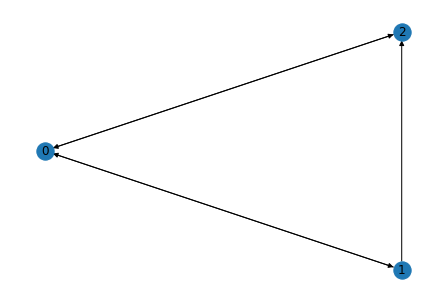

In [39]:
G = nx.DiGraph()
G.add_weighted_edges_from([(0,1,-1),(1,2,1),(2,0,1),(0,2,-1),(1,0,-1)])
nx.draw_shell(G, with_labels=True)

The parameters would be the following:
- $n=5$
- $s=-1$
- $r=[1,-1]$

Note that the order of products in the $r$ list is of no importance. As $r$ is the list of reciprocal edges pair prodcuts, its length is equal to the number of reciprocal pairs of edges in the grapgh. So we could guess the number of edges in the graph based on the length of this list: 

$$n = len(r)+3$$

So basically, we only need two parameters. In the example, we have two reciprocal pairs between nodes (0,2) and (0,1). The first reciprocal pair product of weights is equal to -1 and the second is equal to 1. 

So, following the algorithm, we can go to:

$$n==5 \rightarrow r[0]*r[1] < 0 \rightarrow s==-1$$

Note that the condition on products of elements in the $r$ list allows us to neglect the order of weights. Continuing on the algorithm, we see that that we need to add 2 triads of type ++- and 2 triads of type +-- which is exactly the types of triads that we find in the graph. Maybe the algorithm could have been condensed into a smaller one but there are many exceptions that make it hard to simplify. For example, the case where $n=4, r=[1], s=0$, needs an additonal information about the reciprocal edges in the pair (if both are -1 or both are 1). It is the only case where this information is needed. Compared to the previous algorithm which calculated the number of triads, this algorithm's running time increases of approximately 10%.

In [40]:
def triad_type(triad_edges):
    """ Given all edges between three nodes, find all different types of triads between these three nodes """
    n = len(triad_edges)
    s = sum([edge[-1] for edge in triad_edges])
    r = []
    
    done = []
    for (u,v,w) in triad_edges:
        # Appends the reciprocal products withtout duplicating it
        if (v,u,w) in triad_edges and (v,u,w) not in done:
            r.append(1)
            done.append((u,v,w))
        if (v,u,-w) in triad_edges and (v,u,-w) not in done:
            r.append(-1)
            done.append((u,v,w))

    if n == 3:
        if len(r) != 0:
            raise ValueError('must have no reciprocal pair of edges')
        if s == 3:
            d['+++'] += 1
        elif s == 1:
            d['++-'] += 1
        elif s == -1:
            d['+--'] += 1
        elif s == -3:
            d['---'] += 1
        else:
            raise ValueError('unvalid sum of weights for triad with 3 edges')
            
    elif n == 4:   
        if len(r) != 1:
            raise ValueError('must have one reciprocal pair of edges')
        if r[0] == 1:
            if s == 4:
                d['+++'] += 2
            elif s == 2:
                d['++-'] += 2
            elif s == 0:
                for (u,v,w) in triad_edges:
                    if (v,u,w) in triad_edges:
                        if w == 1:
                            d['+--'] += 1
                        elif w == -1:
                            d['++-'] += 1
                        else:
                            raise ValueError('unvalid weight')
            elif s == -2:
                d['+--'] += 2
            elif s == -4:
                d['---'] += 2
            else:
                raise ValueError('unvalid sum of weights for triad with 4 edges')
        elif r[0] == -1:
            if s == 2:
                d['+++'] += 1
                d['++-'] += 1
            elif s == 0:
                d['++-'] += 1
                d['+--'] += 1
            elif s == -2:
                d['+--'] += 1
                d['---'] += 1
            else:
                 raise ValueError('unvalid sum of weights for triad with 4 edges')
        else:
            raise ValueError('unvalid weight multiplication')
                
    elif n == 5:
        if len(r) != 2:
            raise ValueError('must have 2 reciprocal pairs of edges')
        if r[0] == 1 and r[1] == 1:
            if s == 5:
                d['+++'] += 4
            elif s == 3 or s == 1:
                d['++-'] += 4
            elif s == -1 or s == -3:
                d['+--'] += 4
            elif s == -5:
                d['---'] += 4
            else:
                raise ValueError('unvalid sum of weights for triad with 5 edges')
        elif (r[0]*r[1]) < 0:
            if s == 3:
                d['+++'] += 2
                d['++-'] += 2
            elif s == 1 or s == -1:
                d['++-'] += 2
                d['+--'] += 2
            elif s == -3:
                d['+--'] += 2
                d['---'] += 2
            else:
                raise ValueError('unvalid sum of weights for triad with 5 edges')
        elif  r[0] == -1 and r[1] == -1:
            if s == 1:
                d['+++'] += 1
                d['++-'] += 2
                d['+--'] += 1
            elif s == -1:
                d['++-'] += 1
                d['+--'] += 2
                d['---'] += 1
            else:
                raise ValueError('unvalid sum of weights for triad with 5 edges')
        else:
            raise ValueError('unvalid weight multiplication')
            
    elif n == 6:
        if len(r) != 3:
            raise ValueError('must have 3 reciprocal pairs of edges')
        if r[0] == 1 and r[1] == 1 and r[2] == 1:
            if s == 6:
                d['+++'] += 8
            elif s == 2:
                d['++-'] += 8
            elif s == -2:
                d['+--'] += 8
            elif s == -6:
                d['---'] += 8
            else:
                raise ValueError('unvalid sum of weights for triad with 6 edges')
        elif r[0] == -1 and r[1] == -1 and r[2] == -1:
            if s == 0:
                d['+++'] += 1
                d['++-'] += 3
                d['+--'] += 3
                d['---'] += 1
            else:
                raise ValueError('unvalid sum of weights for triad with 6 edges')
        elif (r[0]*r[1]*r[2]) > 0:
            if s == 2:
                d['+++'] += 2
                d['++-'] += 4
                d['+--'] += 2
            elif s == -2:
                d['++-'] += 2
                d['+--'] += 4
                d['---'] += 2
            else:
                raise ValueError('unvalid sum of weights for triad with 6 edges')
        elif (r[0]*r[1]*r[2]) < 0:
            if s == 4:
                d['+++'] += 4
                d['++-'] += 4         
            elif s == 0:
                d['++-'] += 4
                d['+--'] += 4
            elif s == -4:
                d['+--'] += 4
                d['---'] += 4
            else:
                raise ValueError('unvalid sum of weights for triad with 6 edges')   
        else:
            raise ValueError('unvalid weight multiplication')
            
    else:
        raise ValueError('unvalid number of edges in a triad')
        

This last function permutes the weights of a dataframe:

In [41]:
def permute_weights(dataframe):
    """ Permute the weights of a given network """
    weight_permuted_df = dataframe.copy()
    weight_permuted_df["Weight"] = np.random.RandomState(seed=811).permutation(weight_permuted_df["Weight"])
    return weight_permuted_df

#### Triad types

Now, we can simply apply our `triads` function of each of the datasets.

In [42]:
# Epinions
%time triads(epinions)

CPU times: user 5min 11s, sys: 495 ms, total: 5min 11s
Wall time: 5min 11s


In [43]:
# Slashdot
%time triads(slashdot)

CPU times: user 1min 48s, sys: 172 ms, total: 1min 49s
Wall time: 1min 49s


In [44]:
# Wikipedia
%time triads(wikielec)

CPU times: user 24 s, sys: 35.6 ms, total: 24.1 s
Wall time: 24.1 s


#### Triads type - Permuted weights
In the same way, we calculate the triad types when weights are permuted.

In [45]:
# Epinions permute
%time triads(permute_weights(epinions), permute=True)

CPU times: user 5min 11s, sys: 465 ms, total: 5min 11s
Wall time: 5min 11s


In [46]:
# Slashdot permute
%time triads(permute_weights(slashdot), permute=True)

CPU times: user 1min 49s, sys: 172 ms, total: 1min 50s
Wall time: 1min 50s


In [47]:
# Wikipedia permute
%time triads(permute_weights(wikielec), permute=True)

CPU times: user 23.9 s, sys: 36.4 ms, total: 23.9 s
Wall time: 23.9 s


#### Surprise

In [48]:
# Surprise
Ti = results_table3['|Ti|'].values
p0Ti = results_table3['p0(Ti)'].values
delta = np.repeat(results_table3['|Ti|'].sum(level='Dataset').values, 4, axis=0)
E = delta*p0Ti

results_table3['s(Ti)'] = (Ti - E)/np.sqrt((E*(1 - p0Ti)).astype(float))

#### Display

In [49]:
# Apply the same notation as in the paper
results_table3['|Ti|'] = results_table3['|Ti|'].map("{:,}".format)
results_table3[['p(Ti)','p0(Ti)']] = results_table3[['p(Ti)','p0(Ti)']].applymap("{:.3f}".format)
results_table3['s(Ti)'] = results_table3['s(Ti)'].map("{:.1f}".format)

In [50]:
# Display
display(PAPER_RESULTS_TABLE3)
display(results_table3)

Paper Results - Table 3        |Ti|  p(Ti) p0(Ti)    s(Ti)
Dataset   Triad Ti                                        
Epinions  T3 + + +       11,640,257  0.870  0.621   1881.1
          T1 + - -          947,855  0.071  0.055    249.4
          T2 + + -          698,023  0.052  0.321  -2104.8
          T0 - - -           89,272  0.007  0.003    227.5
Slashdot  T3 + + +        1,266,646  0.840  0.464    926.5
          T1 + - -          109,303  0.072  0.119   -175.2
          T2 + + -          115,884  0.077  0.406   -823.5
          T0 - - -           16,272  0.011  0.012     -8.7
Wikipedia T3 + + +          555,300  0.702  0.489    379.6
          T1 + - -          163,328  0.207  0.106    289.1
          T2 + + -           63,425  0.080  0.395   -572.6
          T0 - - -            8,479  0.011  0.010     10.8

Replication results - Table 3        |Ti|  p(Ti) p0(Ti)    s(Ti)
Dataset   Triad Ti                                              
Epinions  T3 + + +             11,616,708  0.872  0.621   1890.2
          T1 + - -                688,557  0.052  0.055    -55.2
          T2 + + -                924,739  0.069  0.321  -1964.3
          T0 - - -                 87,668  0.007  0.003    220.7
Slashdot  T3 + + +              1,266,646  0.840  0.461    934.5
          T1 + - -                115,884  0.077  0.120   -163.6
          T2 + + -                109,303  0.072  0.407   -837.2
          T0 - - -                 16,272  0.011  0.012    -11.3
Wikipedia T3 + + +                555,300  0.702  0.481    393.2
          T1 + - -                 63,425  0.080  0.110    -83.6
          T2 + + -                163,328  0.207  0.399   -349.4
          T0 - - -                  8,479  0.011  0.010      7.8

### Discussion <a id='Discussion'></a>
##### Types and probabilities
What is evident at first glance is that some rows are switched between what we found and the paper's results. If we look closer, what we see is that T1 and T2 triad types are switched but only the |Ti| and p(Ti) columns of our table (obviously p(Ti) as it is directly linked to |Ti|). How to be sure that we didn't make a mistake ? A first clue is that we found the exact same number of triad types for `slashdot`and `wikielec` datasets and that only T1 and T2 are switched. If we had made a mistake, it would very unlikely that these numbers of triad types were the exact same. Another clue is that the p0(Ti) columns gives very similar results. Of course these results are not the exact same because of the random permutation of the weights. Based on these two clues, we can quite confidently assess that there were a mistake in the paper. Also the number of triad types for `epinions` are not the exact same like the ones of the other datasets because of the different number of edges and nodes that we found previsously. 

##### Surprise
Lastly, we can see that the surprises that we found are also close to the paper ones, except for triad types T1 and T2 because we use these switched types but with the right p0(Ti). For example, if we take `Wikipedia` dataset, the surprise of the paper for T1 is 289.1 when it is -83.6 in our results. Note also that even if we have the exact same results for |Ti|, p(Ti) and p0(Ti) as for the type T0 of `Wikipedia`, the surprise is still not the same (10.8 vs 7.8). This is most likely due to the rounding of results. Indeed, the surprise is very sensible to small changes and different approximations of surprise parameters could lead to different results.